In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader #loads the datsets in batches
import torchvision 
import torch.nn.functional as F
from laplace import Laplace

In [2]:
import matplotlib.pyplot as plt
import numpy as np

Dataset and DataLoader

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # scale to [-1, 1]
])

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform) #around 60,0000
test_dataset  = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform) # around 10,000

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)

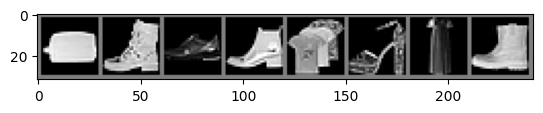

Bag Ankle boot Sneaker Ankle boot T-shirt/top Sandal Dress Ankle boot
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [4]:
# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)  # use next() instead of .next()
classes = train_dataset.classes

# Make a grid from batch
def imshow(img):
    img = img / 2 + 0.5  # unnormalize [-1,1] -> [0,1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show first 8 images
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join(classes[labels[j]] for j in range(8)))
print(classes)

Model

In [5]:
class FashionMNIST_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(FashionMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # two pooling ops: 28→14→7
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # (28→14)
        x = self.pool(torch.relu(self.conv2(x)))  # (14→7)
        x = x.view(x.size(0), -1)  # flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # logits
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FashionMNIST_CNN().to(device)

Training Setup

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100. * correct / len(train_loader.dataset)
    print(f"Epoch {epoch}: Train Loss = {total_loss/len(train_loader):.4f}, Accuracy = {acc:.2f}%")

Evaluation

In [7]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    acc = 100. * correct / len(test_loader.dataset)
    print(f"Test Loss = {test_loss:.4f}, Accuracy = {acc:.2f}%")

Run Training

In [8]:
epochs = 5
for epoch in range(1, epochs+1):
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader, criterion)

Epoch 1: Train Loss = 0.4280, Accuracy = 84.50%
Test Loss = 0.3250, Accuracy = 88.09%
Epoch 2: Train Loss = 0.2727, Accuracy = 89.97%
Test Loss = 0.2697, Accuracy = 90.07%
Epoch 3: Train Loss = 0.2297, Accuracy = 91.61%
Test Loss = 0.2576, Accuracy = 90.66%
Epoch 4: Train Loss = 0.1955, Accuracy = 92.74%
Test Loss = 0.2347, Accuracy = 91.34%
Epoch 5: Train Loss = 0.1692, Accuracy = 93.73%
Test Loss = 0.2439, Accuracy = 91.41%


Visualize Predictions

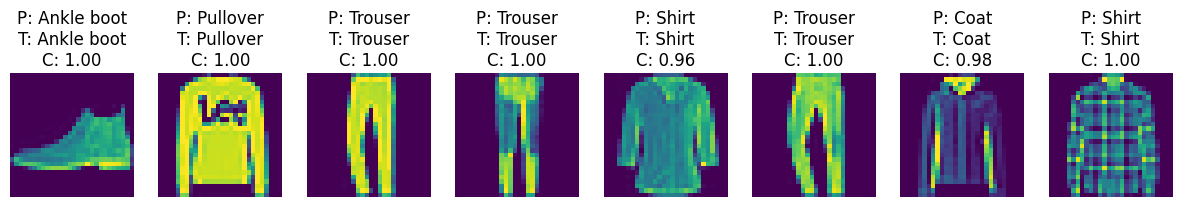

In [9]:
def visualize_predictions_with_confidence(model, test_loader, num_images=8):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    probs = F.softmax(outputs, dim=1)  # convert logits to probabilities
    conf, predicted = torch.max(probs, 1)  # confidence and predicted label

    images = images.cpu()
    predicted = predicted.cpu()
    labels = labels.cpu()
    conf = conf.cpu()

    # Plot images with predicted label, confidence, and true label
    plt.figure(figsize=(15,4))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        img = images[i] / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1,2,0)))
        plt.title(f"P: {classes[predicted[i]]}\nT: {classes[labels[i]]}\nC: {conf[i]:.2f}")
        plt.axis('off')
    plt.show()
visualize_predictions_with_confidence(model, test_loader)

Apply Laplace Approximation

In [10]:
# Use last-layer diagonal Laplace approximation
la = Laplace(model, likelihood='classification',
             subset_of_weights='last_layer',
             hessian_structure='diag')

# Fit on the training loader
la.fit(train_loader)

# Optimize prior precision using marginal likelihood
la.optimize_prior_precision(method='marglik')

C:\Users\sravani\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\laplace\baselaplace.py:435: UserWarning: By default `link_approx` is `probit`. Make sure to set it equals to the way you want to call `la(test_data, pred_type=..., link_approx=...)`.
  warnings.warn(


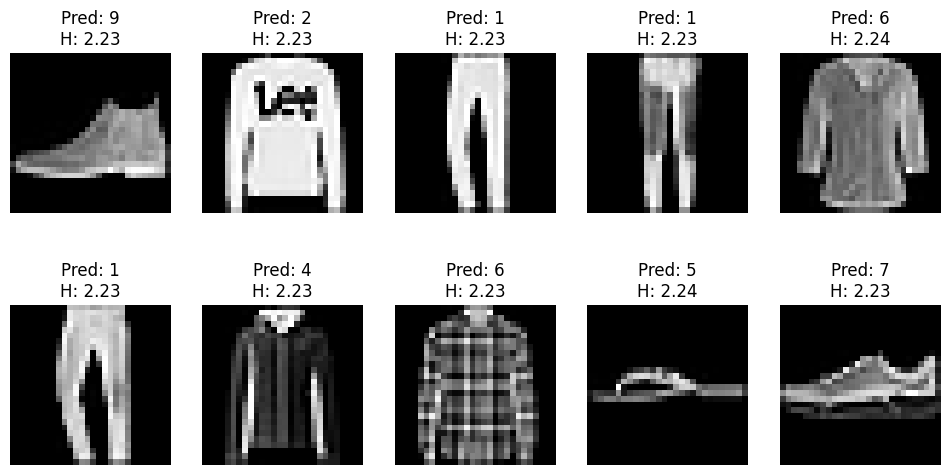

In [11]:
model.eval()
test_iter = iter(test_loader)
images, labels = next(test_iter)
images = images.to(device)

# Predictive distribution
pred_mean = la(images)
pred_proba = torch.softmax(pred_mean, dim=-1)

# Approximate predictive uncertainty (entropy)
entropy = -torch.sum(pred_proba * pred_proba.log(), dim=1)

# Show some predictions and uncertainties
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    img = images[i].cpu().squeeze()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Pred: {pred_proba[i].argmax().item()}\nH: {entropy[i]:.2f}")
    ax.axis('off')
plt.show()